# Task 2:  OSATS Multi-Label Classification

This notebook implements a deep learning aproach for Task 2. The objective is Predict 8 OSATS scores (ranging from 0 to 4) for each surgical video

We will use the previously processed data, as well as those made available by the teacher.

- Input: `.npz` files with `features` of shape `(300, 2048)` representing 300 selected frames per video

- Targets: → vector of 8 integers per video (one per OSATS criterion)


### 1. Inicialization

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import Tensor
from torch.nn import CrossEntropyLoss
from torch.nn import Sequential, Linear, ReLU, LSTM, Module, Conv1d
from torch.nn import Parameter, LayerNorm, TransformerEncoderLayer, TransformerEncoder, Dropout, ModuleList

from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from collections import Counter
from livelossplot import PlotLosses

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()   
print(device)

cuda


In [3]:
# File Paths
PATH_DATA = "../data_preparation/data_processed/kmeans_clustering/"
OUTPUT_FOLDER = "./results/"
GROUND_TRUTH_PATH = "results/ground_truth.csv"
PREDICTIONS_PATH = "results/osats_01_results.csv"

In [4]:
# Constants And Seed
SEED = 42
BATCH_SIZE = 32
NUM_CLASSES = 5

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 2. Data Preparation 

In [5]:
# Dataset 
class OSATSDataset(Dataset):
    def __init__(self, path_data, num_frames=300):
        self.num_frames = num_frames
        
        self.files = sorted([
            os.path.join(path_data, f)
            for f in os.listdir(path_data)
            if f.endswith(".npz")
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        
        video = data["features"]  # (300, 2048)
        label = data["label_task_2"]  # (8,)
        label = label.astype(np.int64) - 1 # [1-5] -> [0-4]

        video_tensor = torch.tensor(video, dtype=torch.float32)  # (300, 2048)
        label_tensor = torch.tensor(label , dtype=torch.long)     # (8,)
        video_name = os.path.splitext(os.path.basename(self.files[idx]))[0]

        return video_tensor, label_tensor, video_name


In [6]:
# Dataloaders
def osats_prepare_data_loaders(test = 0.2, val = 0.1):
    generator = torch.Generator().manual_seed(SEED)

    full_dataset = OSATSDataset(path_data=PATH_DATA)    
    
    total_len = len(full_dataset)
    val_size = int(val * total_len)
    test_size = int(test * total_len)
    train_size = total_len - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)
    
    # DataLoaders 
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dl   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # DataLoaders without Batching
    train_dl_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_dl_all   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_dl_all  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all


In [7]:
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = osats_prepare_data_loaders()

#### 2.1 Visualize Data

In [10]:
def visualize_dataset(train, test, val):
    print(f"Casos de Treino: {len(train.dataset)}")
    print(f"Casos de Validação: {len(val.dataset)}")
    print(f"Casos de Teste: {len(test.dataset)}\n")

    x, y, _ = next(iter(train)) 
    print(f"(TREINO): Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y, _ = next(iter(val)) 
    print(f"(VAL)   : Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y, _ = next(iter(test))
    print(f"(TESTE) : Shape tensor batch -> input: {x.shape}, output: {y.shape}\n")

    print(f'Valor maximo x:{torch.max(x)}\nValor mínimo x:{torch.min(x)}\n')
    print(f'Valor maximo y:{torch.max(y)}\nValor mínimo y:{torch.min(y)}\n')


In [11]:
visualize_dataset(train_dl, test_dl, val_dl)

Casos de Treino: 221
Casos de Validação: 31
Casos de Teste: 62

(TREINO): Shape tensor batch -> input: torch.Size([32, 300, 2048]), output: torch.Size([32, 8])
(VAL)   : Shape tensor batch -> input: torch.Size([31, 300, 2048]), output: torch.Size([31, 8])
(TESTE) : Shape tensor batch -> input: torch.Size([32, 300, 2048]), output: torch.Size([32, 8])

Valor maximo x:8.939702033996582
Valor mínimo x:0.0

Valor maximo y:4
Valor mínimo y:0



### 3. Model

#### 3.1 Architecture

The model receives as input a tensor of shape **[B, T, 2048]**, representing a sequence of frame-level features extracted previously in data preparation.

A BiLSTM with two layers and hidden size 512 (bidirectional) encodes temporal dependencies, producing a [B, T, 1024] output.

A temporal attention mechanism then aggregates this into a single context vector [B, 1024], focusing on the most relevant frames.

After dropout regularization, the context is passed through 8 parallel output heads (Linear(1024 -> 5)), each predicting a class distribution (0–4) for one OSATS criterion. 

Final output: [B, 8, 5].

- Input: **[B, T, 2048]**
- BiLSTM(2048 -> 512 x 2) -> **[B, T, 1024]**
- Temporal Attention -> **[B, 1024]**
- Dropout -> **~ [0.1 - 0.3]**
- Output: 8 Heads: Linear(1024 -> 5) -> **[B, 8, 5]**



In [12]:
class Attention(Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = Linear(hidden_dim, 1)

    def forward(self, x):  # x: [B, T, H]
        attn_scores = self.attn(x).squeeze(-1)  # [B, T]
        attn_weights = F.softmax(attn_scores, dim=1)  # [B, T]
        context = torch.bmm(attn_weights.unsqueeze(1), x).squeeze(1)  # [B, H]
        return context, attn_weights

class OSATSModel_01(Module):
    def __init__(self, input_dim=2048, hidden_dim=512, num_layers=2, num_classes=5, num_targets=8, dropout=0.3):
        super().__init__()
        
        self.bilstm = LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )
        self.attention = Attention(hidden_dim * 2)  # BiLSTM → 2x hidden_dim
        self.dropout = Dropout(dropout)
        self.heads = ModuleList([ Linear(hidden_dim * 2, num_classes) for _ in range(num_targets) ])

    def forward(self, x):  # x: [B, T, 2048]
        lstm_out, _ = self.bilstm(x)  # [B, T, 2*hidden]
        context, attn_weights = self.attention(lstm_out)  # [B, 2*hidden]
        context = self.dropout(context)
        
        outputs = [head(context) for head in self.heads]  # 8 tensors list [B, 5]
        return torch.stack(outputs, dim=1), attn_weights  # [B, 8, 5], [B, T]

In [13]:
model = OSATSModel_01().to(device)

### 4. Model Trainning

#### 4.1 Training Procedure
The model is trained using the AdamW optimizer with weight decay and a learning rate scheduler (**ReduceLROnPlateau**) to adjust learning based on validation loss.

To avoid overfitting and unnecessary computation, **early stopping** is applied — training stops if validation loss does not improve for a given number of epochs.

During training, we generate three live plots in real time:

- **Loss**: Shows training and validation loss over epochs.
- **Accuracy**: Measures the average per-class prediction accuracy across all 8 OSATS criteria.
- **Exact Match**: Tracks how often the model correctly predicts **all 8 scores** simultaneously for a given video (strict correctness).

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                print(f"Validation loss improved.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
def train_model(model, model_path, train_dl, val_dl, criterion, optimizer, scheduler=None, early_stopper=None, device='cpu', num_epochs=20):
    def compute_osats_loss(outputs, labels, criterions):
        loss = 0.0
        for i in range(8):
            loss += criterions[i](outputs[:, i, :], labels[:, i])
        return loss / 8.0
    
    liveloss = PlotLosses()

    best_val_loss = float('inf')
    best_model_state = None

    model.to(device)

    for epoch in range(num_epochs):
        logs = {}

        # Training 
        model.train()
        train_loss = 0.0
        train_total = 0
        train_corrects = 0
        train_exact = 0

        for inputs, labels, _ in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)  # (B, 8, 5) , _
            loss = compute_osats_loss(outputs, labels, criterion)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=-1)
            train_corrects += (preds == labels).sum().item()
            train_exact += ((preds == labels).all(dim=1)).sum().item()
            train_total += labels.numel()

        epoch_train_loss = train_loss / len(train_dl.dataset)
        epoch_train_acc = train_corrects / train_total
        epoch_train_exact = train_exact / len(train_dl.dataset)
        logs['loss'] = epoch_train_loss
        logs['accuracy'] = epoch_train_acc
        logs['exact_match'] = epoch_train_exact

        # Validation
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_corrects = 0
        val_exact = 0

        with torch.no_grad():
            for inputs, labels, _ in val_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs,_ = model(inputs) # (B, 8, 5) , _
                loss = compute_osats_loss(outputs, labels, criterion)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=-1)
                val_corrects += (preds == labels).sum().item()
                val_exact += ((preds == labels).all(dim=1)).sum().item()
                val_total += labels.numel()

        epoch_val_loss = val_loss / len(val_dl.dataset)
        epoch_val_acc = val_corrects / val_total
        epoch_val_exact = val_exact / len(val_dl.dataset)
        logs['val_loss'] = epoch_val_loss
        logs['val_accuracy'] = epoch_val_acc
        logs['val_exact_match'] = epoch_val_exact

        if scheduler:
            scheduler.step(epoch_val_loss)

        if early_stopper:
            early_stopper(epoch_val_loss, model)
            if early_stopper.early_stop:
                print("Early stopping activated.")
                break

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()

        liveloss.update(logs)
        liveloss.send()

    torch.save(best_model_state if best_model_state else model.state_dict(), model_path)


#### 4.2 Hiper-parameters  and Training Strategy

The training setup was carefully configured to handle the challenges of multi-class, multi-criterion classification with strong class imbalance

We use **Focal Loss** instead of the standard CrossEntropyLoss to address the strong class imbalance present in the OSATS criteria scores.

Focal Loss down-weights easy examples and focuses the learning on harder, misclassified ones. This is especially useful when some scores are underrepresented.

To further improve balance, we compute **class weights-per-criterion** 

We set the initial learning rate value to ``0.0005`` instead of the usual 0.001 because we are using attention mechanisms

We set a high epoch value (``100``) due to the use of early stop

In [17]:
class FocalLoss(Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha # Weights tensor
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=-1)      # [B, C]
        probs = torch.exp(log_probs)                   # [B, C]

        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1)).float()  # [B, C]

        ce_loss = -targets_one_hot * log_probs         # Cross entropy 
        focal_term = (1 - probs) ** self.gamma         # Peso adicional

        loss = focal_term * ce_loss                    # Focal loss 

        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)       # [C]
            loss *= alpha.unsqueeze(0)                 # broadcasting to [B, C]

        loss = loss.sum(dim=-1)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # [B]

In [18]:
def extract_labels_from_dataloader(dataloader):
    all_labels = []
    for _, labels, _ in dataloader:
        all_labels.append(labels)
    return torch.cat(all_labels, dim=0)
    
def compute_class_weights(labels, num_classes=NUM_CLASSES):
    counts = Counter(labels)
    total = sum(counts.values())
    weights = torch.tensor(
        [total / (counts[i] if counts[i] > 0 else 1) for i in range(num_classes)],
        dtype=torch.float32
    )
    weights = weights / weights.sum()  # normalization
    return weights

train_labels = extract_labels_from_dataloader(train_dl_all)

In [31]:
# Hiper-Parameters
CRITERION = [FocalLoss(alpha = compute_class_weights(train_labels[:, i]), gamma=2.0) for i in range(8)]
EPOCHS = 100
WEIGHT_DECAY = 0.01
LEARNING_RATE = 0.0005
OPTIMIZER = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.5, patience=3)
early_stopper = EarlyStopping(patience=20, verbose=True)

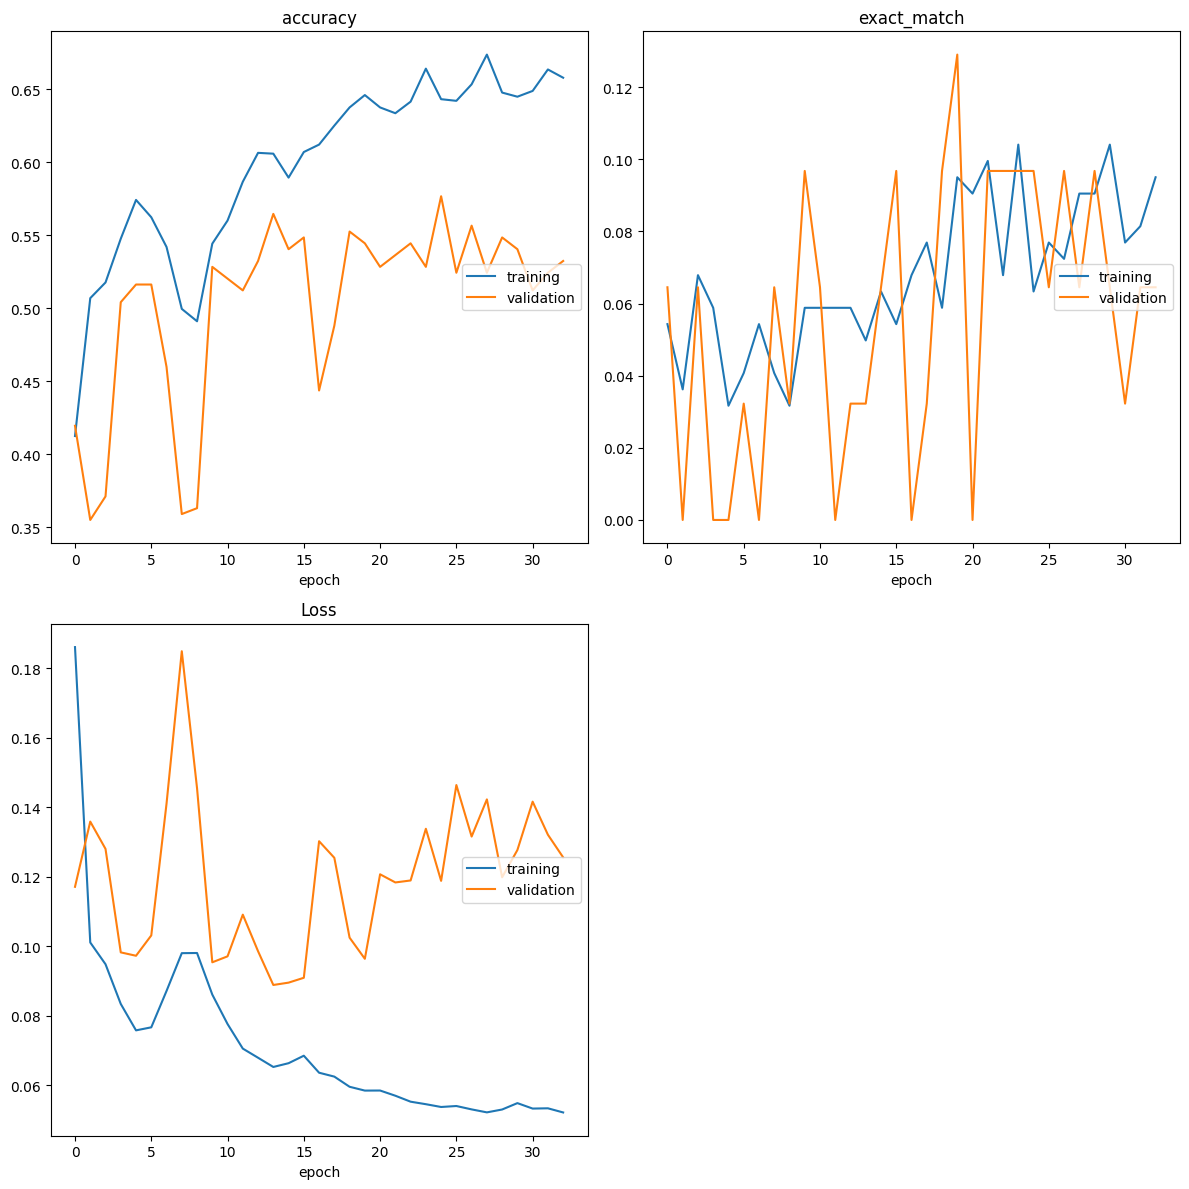

accuracy
	training         	 (min:    0.412, max:    0.674, cur:    0.658)
	validation       	 (min:    0.355, max:    0.577, cur:    0.532)
exact_match
	training         	 (min:    0.032, max:    0.104, cur:    0.095)
	validation       	 (min:    0.000, max:    0.129, cur:    0.065)
Loss
	training         	 (min:    0.052, max:    0.186, cur:    0.052)
	validation       	 (min:    0.089, max:    0.185, cur:    0.126)
EarlyStopping counter: 20/20
Early stopping activated.


In [32]:
train_model(
    model=model,
    model_path="osats_01.pth",
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    scheduler=SCHEDULER,
    early_stopper = early_stopper,
    device=device,
    num_epochs=EPOCHS
)

### 5. Model Evaluation

#### 5.1 Calculated Metrics
 - F1-Score
 - Accuracy
 - Expected Cost

will be calculated individually for each OSATS field.

The steps for the challenge output are being followed: csv file created for the ground truth and model predictions.

In [ ]:
# Export Ground Truth
video_ids, labels = [], []

for _, label_tensor, video_name in test_dl_all.dataset:
    video_ids.append(video_name)
    labels.append((label_tensor + 1).tolist())

labels_matrix = pd.DataFrame(labels, columns=[
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
    "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"
])

df = pd.concat([pd.Series(video_ids, name="VIDEO"), labels_matrix], axis=1)

output_path = os.path.join(OUTPUT_FOLDER, "ground_truth.csv")
df.to_csv(output_path, index=False)
print(f"Saved ground truth to {output_path}")

In [33]:
# Create the predictions csv file
def predict_and_export_csv(model_path: str, model_class, model_name: str, dataloader, batch_size: int = 8):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    if isinstance(dataloader.dataset, Subset):
        base_dataset = dataloader.dataset.dataset
        indices = dataloader.dataset.indices
    else:
        base_dataset = dataloader.dataset
        indices = list(range(len(base_dataset)))

    # New smaller dataloader 
    subset = torch.utils.data.Subset(base_dataset, indices)
    small_loader = DataLoader(
        dataset=subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    results = []

    with torch.no_grad():
        for inputs, _, video_names in small_loader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)  # (B, 8, 5), _
            _, predicted = torch.max(outputs, dim=2)  # (B, 8)
            predicted = (predicted.cpu().numpy() + 1).tolist()

            for name, pred in zip(video_names, predicted):
                results.append([name] + pred)

            del inputs, outputs, predicted
            torch.cuda.empty_cache()

    columns = ["VIDEO", "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
               "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"]

    df = pd.DataFrame(results, columns=columns)
    output_path = os.path.join(OUTPUT_FOLDER, f"{model_name}_results.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved OSATS predictions to {output_path}")

In [34]:
predict_and_export_csv(model_path="osats_01.pth", model_class=OSATSModel_01, model_name="osats_01", dataloader=test_dl_all)

Saved OSATS predictions to ./results/osats_01_results.csv


#### 5.2 Metrics Calculated


🔹 OSATS_RESPECT — F1-score (macro / DSC): 0.4038
🔹 OSATS_RESPECT — Expected Cost: 0.5323


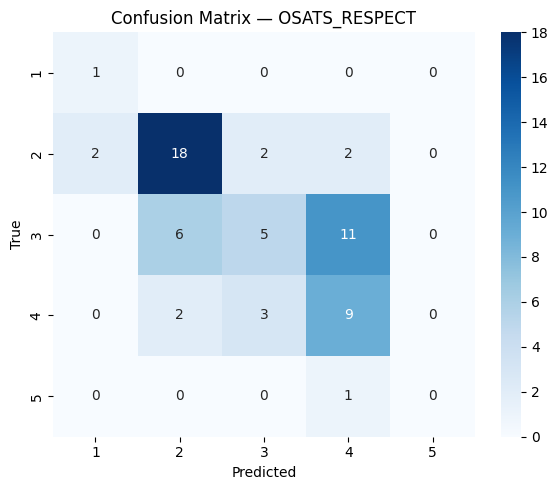


🔹 OSATS_MOTION — F1-score (macro / DSC): 0.4290
🔹 OSATS_MOTION — Expected Cost: 0.5323


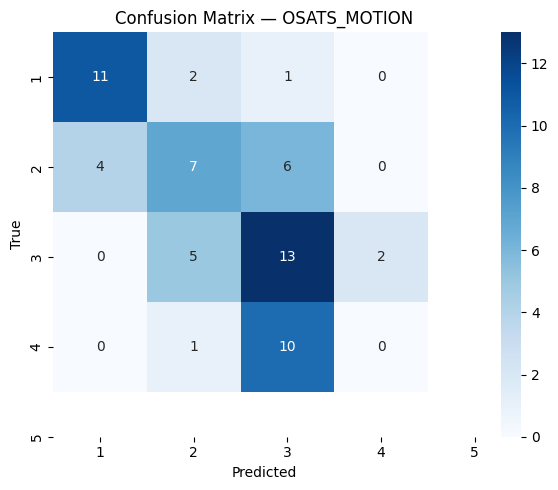


🔹 OSATS_INSTRUMENT — F1-score (macro / DSC): 0.5369
🔹 OSATS_INSTRUMENT — Expected Cost: 0.4516


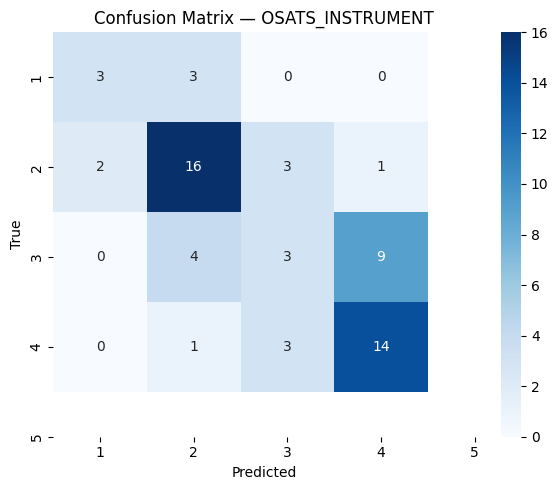


🔹 OSATS_SUTURE — F1-score (macro / DSC): 0.3439
🔹 OSATS_SUTURE — Expected Cost: 0.6774


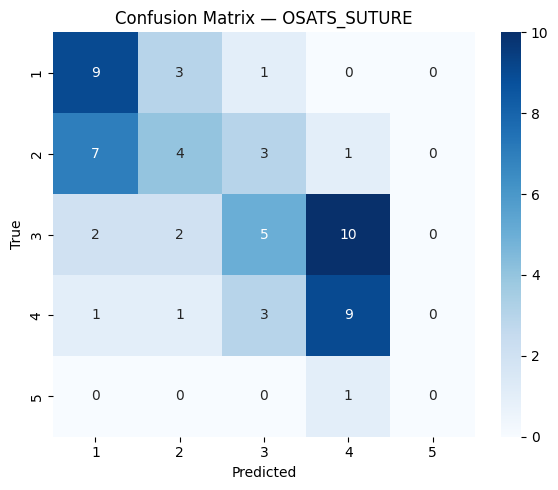


🔹 OSATS_FLOW — F1-score (macro / DSC): 0.5442
🔹 OSATS_FLOW — Expected Cost: 0.4839


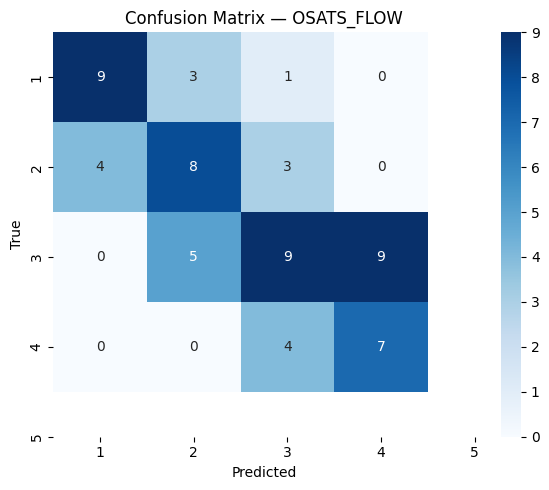


🔹 OSATS_KNOWLEDGE — F1-score (macro / DSC): 0.4049
🔹 OSATS_KNOWLEDGE — Expected Cost: 0.5968


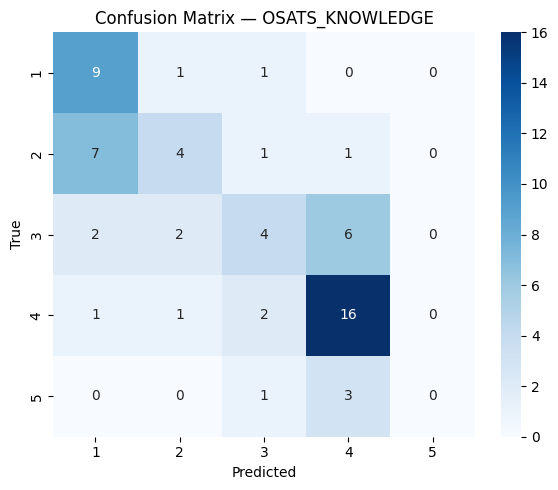


🔹 OSATS_PERFORMANCE — F1-score (macro / DSC): 0.3785
🔹 OSATS_PERFORMANCE — Expected Cost: 0.5968


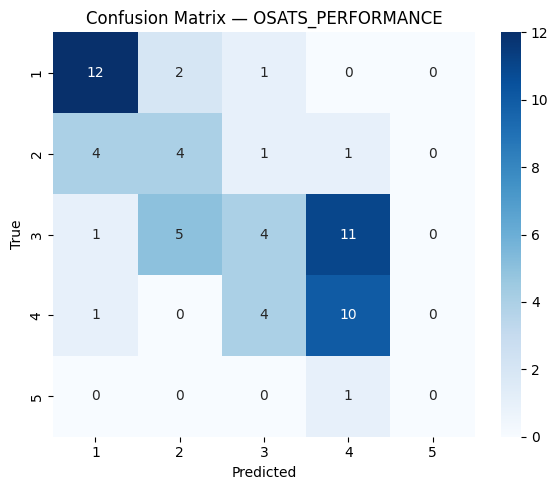


🔹 OSATSFINALQUALITY — F1-score (macro / DSC): 0.4017
🔹 OSATSFINALQUALITY — Expected Cost: 0.5968


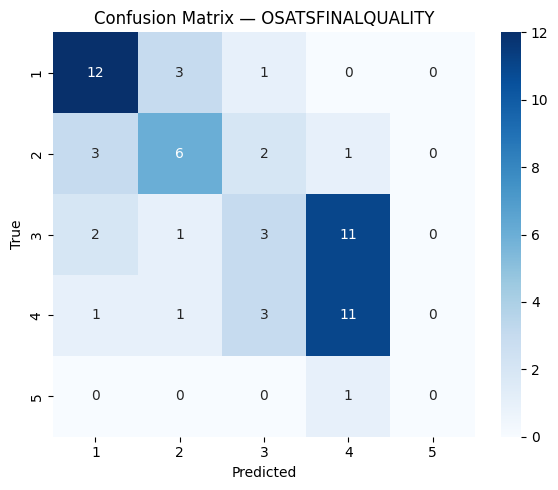

In [35]:
df_gt = pd.read_csv(GROUND_TRUTH_PATH)
df_pred = pd.read_csv(PREDICTIONS_PATH)

# Merge
df = pd.merge(df_gt, df_pred, on="VIDEO", suffixes=('_gt', '_pred'))

osats_criteria = [
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
    "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"
]

for criterion in osats_criteria:
    gt_col = f"{criterion}_gt"
    pred_col = f"{criterion}_pred"

    # Converter 1–5 → 0–4
    df[[gt_col, pred_col]] = df[[gt_col, pred_col]] - 1

    # F1 macro
    f1 = f1_score(df[gt_col], df[pred_col], average='macro')
    print(f"\n🔹 {criterion} — F1-score (macro / DSC): {f1:.4f}")

    # Expected Cost
    cost_matrix = [[abs(i - j) for j in range(NUM_CLASSES)] for i in range(NUM_CLASSES)]
    expected_cost = np.mean([
        cost_matrix[gt][pred]
        for gt, pred in zip(df[gt_col], df[pred_col])
    ])
    print(f"🔹 {criterion} — Expected Cost: {expected_cost:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(df[gt_col], df[pred_col])
    class_names = ["1", "2", "3", "4", "5"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {criterion}")
    plt.tight_layout()
    plt.show()

#### 5.3 Exact Match

In this box we calculate how many times the model predicts all 8 values correctly

Match Accuracy: 0.0806



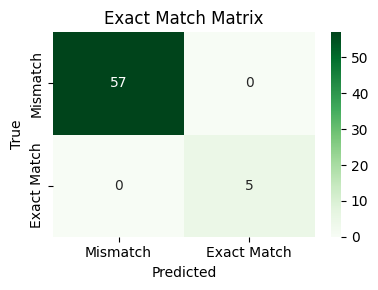

In [36]:
gt_matrix = df[[f"{c}_gt" for c in osats_criteria]].values
pred_matrix = df[[f"{c}_pred" for c in osats_criteria]].values
exact_match = np.all(gt_matrix == pred_matrix, axis=1).astype(int)  # 1 = match, 0 = mismatch

accuracy = exact_match.mean()
print(f"Match Accuracy: {accuracy:.4f}\n")

cm = confusion_matrix(exact_match, exact_match, labels=[0, 1])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Mismatch", "Exact Match"], yticklabels=["Mismatch", "Exact Match"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Exact Match Matrix")
plt.tight_layout()
plt.show()